# 201805071 BATUHAN EMRE YEŞİLYAYLA
# 201805050 BERK OĞUZ
# BİG DATA FİNAL PROJESİ

In [1]:
!pip install findspark
!pip install psutil

import platform
import socket

hostname = socket.gethostname()
ip_address = socket.gethostbyname(hostname)
computer_name = platform.node()
system_info = platform.uname()
cpu_info = platform.processor()

print("Hostname: ", hostname)
print("IP Address: ", ip_address)
print("Computer Name: ", computer_name)
print("System Info: ")
print(f"  System: {system_info.system}")
print(f"  Node Name: {system_info.node}")
print(f"  Release: {system_info.release}")
print(f"  Version: {system_info.version}")
print(f"  Machine: {system_info.machine}")
print(f"  Processor: {system_info.processor}")
print("CPU Info: ", cpu_info)


Hostname:  16fa0927b362
IP Address:  172.18.0.2
Computer Name:  16fa0927b362
System Info: 
  System: Linux
  Node Name: 16fa0927b362
  Release: 5.15.167.4-microsoft-standard-WSL2
  Version: #1 SMP Tue Nov 5 00:21:55 UTC 2024
  Machine: x86_64
  Processor: x86_64
CPU Info:  x86_64


In [2]:
import findspark
findspark.init()
import pyspark 

from pyspark import SparkContext
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

In [3]:
from pyspark.ml.recommendation import ALS

appName = "Spark Recommend System"
spark = SparkSession \
    .builder \
    .appName(appName) \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

sc=spark.sparkContext
sc

<SparkContext master=local[*] appName=Spark Recommend System>

In [4]:
books = spark.read.csv('Books.csv', inferSchema=True, header=True)
users = spark.read.csv('Users.csv', inferSchema=True, header=True)
ratings = spark.read.csv('Ratings.csv', inferSchema=True, header=True)

## 1)PREPROCESSİNG

In [5]:
books=books.drop("Image-URL-S")
books=books.drop("Image-URL-M")
books=books.drop("Image-URL-L")

books=books.dropna()
books=books.dropDuplicates(subset=["Book-Title"])
books.show(10)

+----------+--------------------+-------------------+-------------------+--------------------+
|      ISBN|          Book-Title|        Book-Author|Year-Of-Publication|           Publisher|
+----------+--------------------+-------------------+-------------------+--------------------+
|0590567330| A Light in the S...|        Karen Hesse|               1999|Hyperion Books fo...|
|0451205480| Murder of a Slee...|     Denise Swanson|               2002|         Signet Book|
|0671019155| Q-Space (Star Tr...|           Greg Cox|               1998|           Star Trek|
|0440987261| This Place Has N...|     Paula Danziger|               1987|Random House Chil...|
|0452279186|                !Yo!|      Julia Alvarez|               1997|         Plume Books|
|0060169419|"A Wing and a Pra...|    Harry H. Crosby|               1993|       Harpercollins|
|0237519984|"Active Drama Pla...|     Sheree Vickers|               1999|  Evans Brothers Ltd|
|0486205371|"Best \Thinking M...|   Jacques Futrel

In [6]:
import pandas as pd

books_pd=books.toPandas()
isbn_mapping = {isbn: index for index, isbn in enumerate(books_pd['ISBN'].unique())}
books_pd['newISBN'] = books_pd['ISBN'].map(isbn_mapping)
print(books_pd.head())


         ISBN                                         Book-Title  \
0  0590567330   A Light in the Storm: The Civil War Diary of ...   
1  0451205480   Murder of a Sleeping Beauty (Scumble River My...   
2  0671019155   Q-Space (Star Trek The Next Generation, Book 47)   
3  0440987261   This Place Has No Atmosphere (Laurel-Leaf Books)   
4  0452279186                                               !Yo!   

      Book-Author Year-Of-Publication                    Publisher  newISBN  
0     Karen Hesse                1999  Hyperion Books for Children        0  
1  Denise Swanson                2002                  Signet Book        1  
2        Greg Cox                1998                    Star Trek        2  
3  Paula Danziger                1987   Random House Childrens Pub        3  
4   Julia Alvarez                1997                  Plume Books        4  


In [7]:
books_new=spark.createDataFrame(books_pd)

In [8]:
books_new.show(10)


+----------+--------------------+-------------------+-------------------+--------------------+-------+
|      ISBN|          Book-Title|        Book-Author|Year-Of-Publication|           Publisher|newISBN|
+----------+--------------------+-------------------+-------------------+--------------------+-------+
|0590567330| A Light in the S...|        Karen Hesse|               1999|Hyperion Books fo...|      0|
|0451205480| Murder of a Slee...|     Denise Swanson|               2002|         Signet Book|      1|
|0671019155| Q-Space (Star Tr...|           Greg Cox|               1998|           Star Trek|      2|
|0440987261| This Place Has N...|     Paula Danziger|               1987|Random House Chil...|      3|
|0452279186|                !Yo!|      Julia Alvarez|               1997|         Plume Books|      4|
|0060169419|"A Wing and a Pra...|    Harry H. Crosby|               1993|       Harpercollins|      5|
|0237519984|"Active Drama Pla...|     Sheree Vickers|               1999|

In [9]:
books_new.count()

242132

In [10]:
users=users.dropna()
users=users.dropDuplicates()
users.show(10)
users.count()

+-------+--------------------+----+
|User-ID|            Location| Age|
+-------+--------------------+----+
|    177|amsterdam, n/a, n...|46.0|
|    342|sokoto, niedersac...|28.0|
|    700|georgetown, n/a, ...|16.0|
|    761|fuzhou, fujian, c...|30.0|
|   1382|phoenix, arizona,...|33.0|
|   1628|lagos, lagos, nig...|20.0|
|   1845|fredericksburg, v...|34.0|
|   2386|pittsboro, north ...|40.0|
|   2471|quezon city, metr...|19.0|
|   2494|hammer, wisconsin...|27.0|
+-------+--------------------+----+
only showing top 10 rows



168340

In [11]:
ratings=ratings.dropna()
ratings=ratings.dropDuplicates()
ratings.show(10)
ratings.count()

+-------+----------+-----------+
|User-ID|      ISBN|Book-Rating|
+-------+----------+-----------+
| 276875|8806155873|          0|
| 277042|0446611212|          8|
| 277187|038528859X|          0|
| 277195|006251170X|          0|
| 277427|042514755X|          0|
| 277427|0915943263|          0|
| 277427|0930014464|          0|
| 277478|034066049X|          0|
| 277478|0440234743|          0|
| 277478|0860685179|          0|
+-------+----------+-----------+
only showing top 10 rows



1149780

In [12]:
spark_df=ratings.join(books_new,"ISBN")
spark_df.show(10)
spark_df.count()

+----------+-------+-----------+--------------------+----------------+-------------------+--------------------+-------+
|      ISBN|User-ID|Book-Rating|          Book-Title|     Book-Author|Year-Of-Publication|           Publisher|newISBN|
+----------+-------+-----------+--------------------+----------------+-------------------+--------------------+-------+
|0001048473|  23902|          0|Nothing Can Be Be...|Barns &amp; Budd|               1996|            Atlantic|  10691|
|0001372564|  16319|          0|       Which Colour?|     Sue Dreamer|               1989|HarperCollins Pub...|  57662|
|0001382381|  26583|          0|Huck Scarry's Ste...|     Huck Scarry|               1979|HarperCollins Pub...| 181082|
|0001718126| 176062|          0|ARE YOU MY MOTHER...|           Seuss|               1993|HarperCollins Pub...| 194106|
|0001840517| 114216|          0|                Bess|   Robert Leeson|               1975|             Collins|  79340|
|0001848445|  11676|          0| THE COA

883075

In [13]:
spark_df=spark_df.dropna()

In [14]:
spark_df=spark_df.join(users,"User-ID")
spark_df.show(10)
spark_df.count()

+-------+----------+-----------+--------------------+--------------------+-------------------+--------------------+-------+--------------------+----+
|User-ID|      ISBN|Book-Rating|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|newISBN|            Location| Age|
+-------+----------+-----------+--------------------+--------------------+-------------------+--------------------+-------+--------------------+----+
|     78|0394895894|          8|The Ruby in the S...|      PHILIP PULLMAN|               1988|         Laurel Leaf| 113631|oakland, californ...|18.0|
|     85|0340767936|          5|      Turning Thirty|          Mike Gayle|               2000|Hodder &amp; Stou...| 191962|london, england, ...|41.0|
|     85|0743403843|          0|            Decipher|         Stel Pavlou|               2002|Simon &amp; Schus...|   3979|london, england, ...|41.0|
|    133|0345372700|         10|If I Ever Get Bac...|      LEWIS GRIZZARD|               1991|    Ba

646957

In [15]:
spark_df=spark_df.dropna()

In [16]:
spark_df.show(10)

+-------+----------+-----------+--------------------+--------------------+-------------------+--------------------+-------+--------------------+----+
|User-ID|      ISBN|Book-Rating|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|newISBN|            Location| Age|
+-------+----------+-----------+--------------------+--------------------+-------------------+--------------------+-------+--------------------+----+
|     78|0394895894|          8|The Ruby in the S...|      PHILIP PULLMAN|               1988|         Laurel Leaf| 113631|oakland, californ...|18.0|
|     85|0340767936|          5|      Turning Thirty|          Mike Gayle|               2000|Hodder &amp; Stou...| 191962|london, england, ...|41.0|
|     85|0743403843|          0|            Decipher|         Stel Pavlou|               2002|Simon &amp; Schus...|   3979|london, england, ...|41.0|
|    133|0345372700|         10|If I Ever Get Bac...|      LEWIS GRIZZARD|               1991|    Ba

In [17]:
unique_newISBN_count = books_new.select("newISBN").distinct().count()
print("newISBN sütunundaki benzersiz değer sayısı:", unique_newISBN_count)

newISBN sütunundaki benzersiz değer sayısı: 242132


In [18]:
spark_df.printSchema()

root
 |-- User-ID: integer (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Book-Rating: integer (nullable = true)
 |-- Book-Title: string (nullable = true)
 |-- Book-Author: string (nullable = true)
 |-- Year-Of-Publication: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- newISBN: long (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: string (nullable = true)



In [19]:
from pyspark.sql.functions import col

spark_df = spark_df.filter(col("Book-Rating") != 0)
spark_df = spark_df.filter(col("Book-Author") != "Not Applicable (Na )")
spark_df.show(10)
spark_df.count()

+-------+----------+-----------+--------------------+-------------------+-------------------+--------------------+-------+--------------------+----+
|User-ID|      ISBN|Book-Rating|          Book-Title|        Book-Author|Year-Of-Publication|           Publisher|newISBN|            Location| Age|
+-------+----------+-----------+--------------------+-------------------+-------------------+--------------------+-------+--------------------+----+
|     78|0394895894|          8|The Ruby in the S...|     PHILIP PULLMAN|               1988|         Laurel Leaf| 113631|oakland, californ...|18.0|
|     85|0340767936|          5|      Turning Thirty|         Mike Gayle|               2000|Hodder &amp; Stou...| 191962|london, england, ...|41.0|
|    133|0345372700|         10|If I Ever Get Bac...|     LEWIS GRIZZARD|               1991|    Ballantine Books| 104195|jacksonville, flo...|45.0|
|    183|8476409419|          8|Estudios sobre el...|Jose Ortega Y Gaset|               2001|Downtown Book

231289

In [20]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import BooleanType

def is_valid_year(year):
    try:
        year = int(year)
        return 1970 <= year <= 2023
    except ValueError:
        return False

is_valid_year_udf = udf(is_valid_year, BooleanType())

filtered_df = spark_df.filter(is_valid_year_udf(col('Year-Of-Publication')))
filtered_df = filtered_df.withColumn('Year-Of-Publication', col('Year-Of-Publication').cast('int'))
filtered_rdd = filtered_df.rdd

mapped_rdd = filtered_rdd.map(lambda row: (row['Year-Of-Publication'], (row['Book-Rating'], 1)))

reduce_output = mapped_rdd.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

average_ratings_rdd = reduce_output.map(lambda x: (x[0], x[1][0] / x[1][1]))

result = average_ratings_rdd.collect()

sorted_result = sorted(result, key=lambda x: x[1], reverse=True)[:10]
top_years_dict = {year: count for year, count in sorted_result}
top_years_dict


{2006: 9.0,
 2005: 8.15,
 1971: 8.1171875,
 1970: 8.10958904109589,
 1974: 8.077844311377245,
 2004: 7.925047438330171,
 1976: 7.8913813459268,
 1972: 7.887218045112782,
 2003: 7.871341800110436,
 1973: 7.847117794486215}

In [21]:
spark_df=filtered_df
spark_df.printSchema()

root
 |-- User-ID: integer (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Book-Rating: integer (nullable = true)
 |-- Book-Title: string (nullable = true)
 |-- Book-Author: string (nullable = true)
 |-- Year-Of-Publication: integer (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- newISBN: long (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: string (nullable = true)



## 2)Visualition

In [22]:
df_pandas = pd.DataFrame(list(top_years_dict.items()), columns=['Year', 'Avarage Ratings'])
print(df_pandas)

   Year  Avarage Ratings
0  2006         9.000000
1  2005         8.150000
2  1971         8.117188
3  1970         8.109589
4  1974         8.077844
5  2004         7.925047
6  1976         7.891381
7  1972         7.887218
8  2003         7.871342
9  1973         7.847118


<Axes: xlabel='Year', ylabel='Avarage Ratings'>

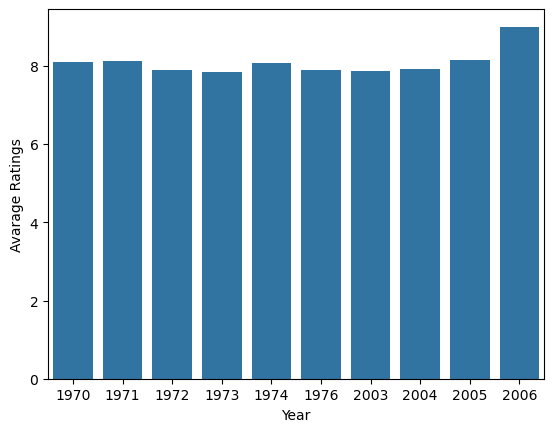

In [23]:
import seaborn as sns
sns.barplot(x="Year",y="Avarage Ratings",data=df_pandas)

In [24]:
rdd = spark_df.rdd
mapped_rdd = rdd.map(lambda row: (row['Year-Of-Publication'], 1))
reduce_output = mapped_rdd.reduceByKey(lambda x, y: x + y)
result = reduce_output.collect()
sorted_result = sorted(result, key=lambda x: x[1], reverse=True)[:10]
top_years_dict_count = {year: count for year, count in sorted_result}
top_years_dict_count

{2002: 22143,
 2003: 19921,
 2001: 18682,
 2000: 16545,
 1999: 16442,
 1998: 14685,
 1997: 13029,
 1996: 12906,
 1995: 11018,
 1994: 9927}

In [25]:
import pandas as pd
df_pandas = pd.DataFrame(list(top_years_dict_count.items()), columns=['Year', 'Book Count'])
print(df_pandas)

   Year  Book Count
0  2002       22143
1  2003       19921
2  2001       18682
3  2000       16545
4  1999       16442
5  1998       14685
6  1997       13029
7  1996       12906
8  1995       11018
9  1994        9927


<Axes: xlabel='Year', ylabel='Book Count'>

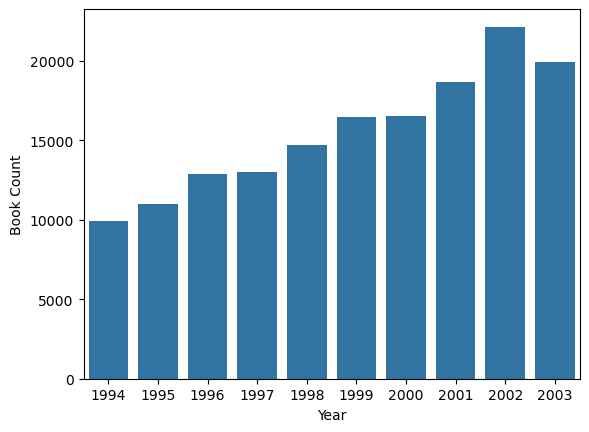

In [26]:
import seaborn as sns

sns.barplot(x="Year",y="Book Count",data=df_pandas)

<Axes: xlabel='Book-Rating', ylabel='count'>

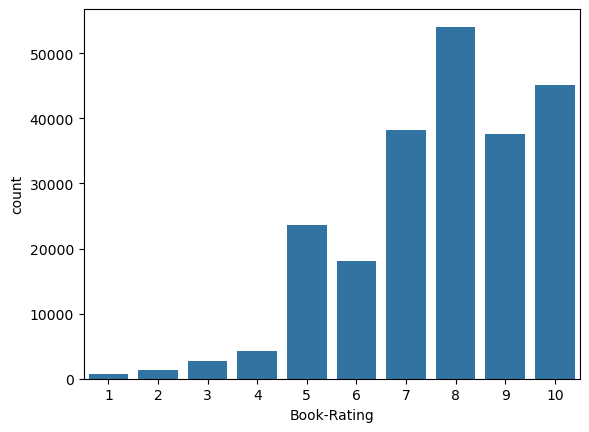

In [27]:
output=spark_df.groupby("Book-Rating").count().toPandas()
sns.barplot(x=output["Book-Rating"],y=output["count"],data=output)

In [28]:
from pyspark.sql.functions import desc

top_authors_df =books.groupby('Book-Author').count() \
                   .orderBy(desc('count')) \
                   .limit(10)


In [29]:
top_authors_df.show(10)

+--------------------+-----+
|         Book-Author|count|
+--------------------+-----+
| William Shakespeare|  491|
|     Agatha Christie|  466|
|       Ann M. Martin|  390|
|       Carolyn Keene|  371|
|     Francine Pascal|  339|
|        Stephen King|  327|
|    Barbara Cartland|  292|
|        Isaac Asimov|  278|
|         R. L. Stine|  276|
|Not Applicable (Na )|  276|
+--------------------+-----+



In [30]:
top_authors_pd = top_authors_df.limit(10).toPandas()
print(top_authors_pd)

            Book-Author  count
0   William Shakespeare    491
1       Agatha Christie    466
2         Ann M. Martin    390
3         Carolyn Keene    371
4       Francine Pascal    339
5          Stephen King    327
6      Barbara Cartland    292
7          Isaac Asimov    278
8           R. L. Stine    276
9  Not Applicable (Na )    276


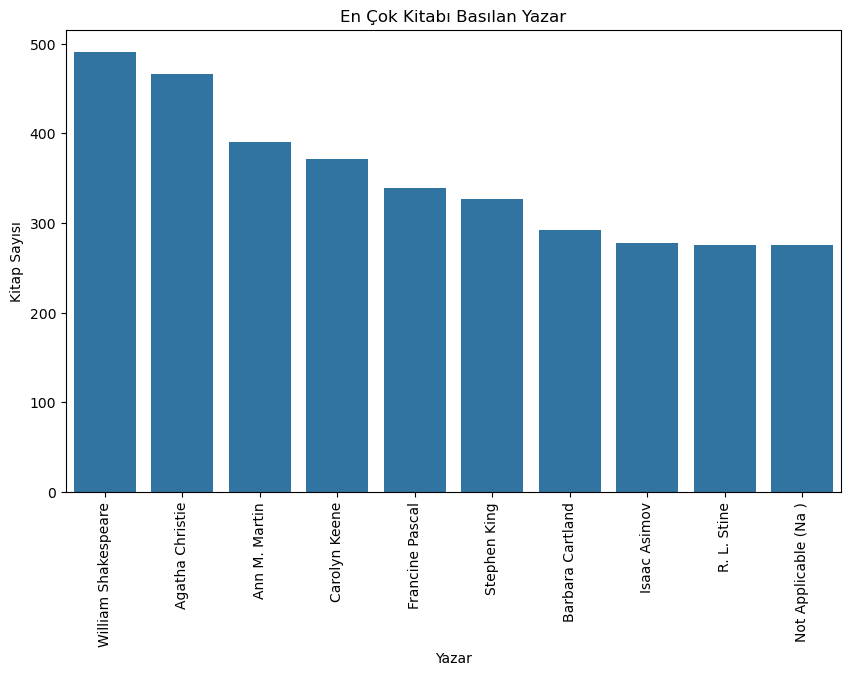

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=top_authors_pd["Book-Author"], y=top_authors_pd["count"], data=top_authors_pd)
plt.xticks(rotation=90)  
plt.xlabel('Yazar')
plt.ylabel('Kitap Sayısı')
plt.title('En Çok Kitabı Basılan Yazar')
plt.show()

In [32]:
from pyspark.sql.functions import avg
author_book_counts_df = spark_df.groupBy('Book-Author').count()

top_authors_avg_rating_df = spark_df.join(top_authors_df, 'Book-Author') \
                               .groupBy('Book-Author') \
                               .agg(avg('Book-Rating').alias('Average-Rating'))
top_authors_avg_rating_df.show()

+-------------------+-----------------+
|        Book-Author|   Average-Rating|
+-------------------+-----------------+
|       Stephen King| 7.98452157598499|
|       Isaac Asimov|8.037974683544304|
|William Shakespeare|8.367272727272727|
|    Francine Pascal|6.825806451612904|
|    Agatha Christie|7.963718820861678|
|        R. L. Stine|6.955380577427822|
|      Ann M. Martin|7.057471264367816|
|      Carolyn Keene|7.963350785340314|
|   Barbara Cartland|              6.6|
+-------------------+-----------------+



In [33]:
top_authors_avg_rating_pd = top_authors_avg_rating_df.limit(10).toPandas()
top_authors_avg_rating_pd

,Book-Author,Average-Rating
0,Stephen King,7.984522
1,Isaac Asimov,8.037975
2,William Shakespeare,8.367273
3,Francine Pascal,6.825806
4,Agatha Christie,7.963719
5,R. L. Stine,6.955381
6,Ann M. Martin,7.057471
7,Carolyn Keene,7.963351
8,Barbara Cartland,6.600000


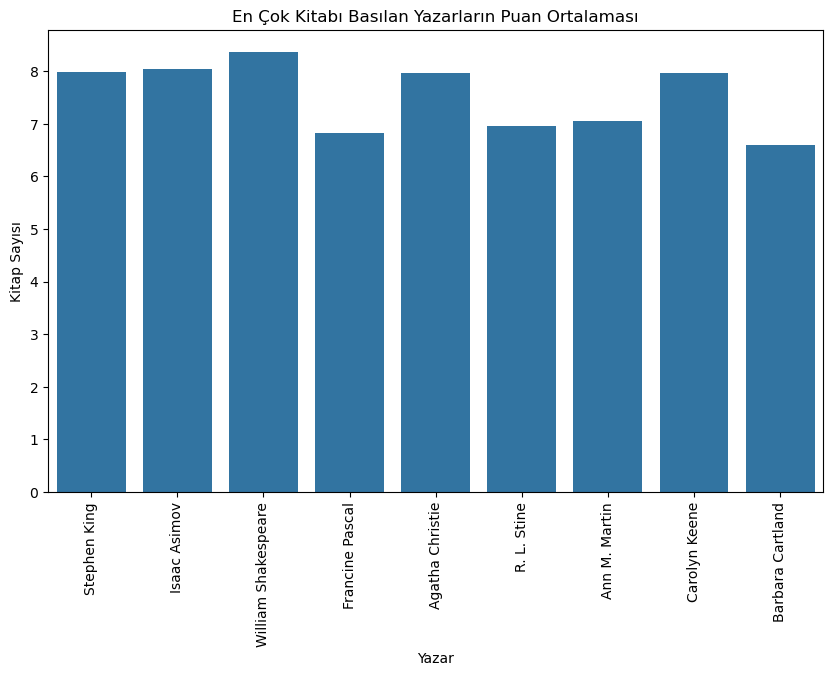

In [34]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_authors_avg_rating_pd["Book-Author"], y=top_authors_avg_rating_pd["Average-Rating"], data=top_authors_avg_rating_pd)
plt.xticks(rotation=90)  
plt.xlabel('Yazar')
plt.ylabel('Kitap Sayısı')
plt.title('En Çok Kitabı Basılan Yazarların Puan Ortalaması')
plt.show()

## 3)ALS Model ile Eğitim

In [35]:
(train, test) = spark_df.randomSplit([0.7, 0.3])

In [36]:
train.count()

157794

In [37]:
test.count()

68099

In [38]:
spark_df.count()

225893

In [39]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd

ranks = [10, 50, 200]
iterations = [10, 12, 15]
lambdas = [0.01, 0.1]
results = []

best_rmse = float("inf")
best_model = None
best_params = None

for rank in ranks:
    for iteration in iterations:
        for reg_param in lambdas:
            als = ALS(maxIter=iteration, regParam=reg_param, rank=rank, seed=5071,
                      userCol="User-ID", itemCol="newISBN", ratingCol="Book-Rating",
                      coldStartStrategy="drop")

            model = als.fit(train)

            predictions = model.transform(test)
            
            evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="Book-Rating", predictionCol="prediction")
            evaluator_mse = RegressionEvaluator(metricName="mse", labelCol="Book-Rating", predictionCol="prediction")
            rmse = evaluator_rmse.evaluate(predictions)
            mse = evaluator_mse.evaluate(predictions)
            
            print(f"Parameters: Rank={rank}, Iteration={iteration}, Lambda={reg_param}")
            print(f"RMSE: {rmse}, MSE: {mse}")
            results.append({"rank": rank, "iteration": iteration, "lambda": reg_param, "rmse": rmse})

            print("---------------------------------------------")
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
                best_params = {"rank": rank, "iteration": iteration, "lambda": reg_param}

print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)





Parameters: Rank=10, Iteration=10, Lambda=0.01
RMSE: 7.396422025149701, MSE: 54.7070587741196
---------------------------------------------
Parameters: Rank=10, Iteration=10, Lambda=0.1
RMSE: 4.248729438260892, MSE: 18.05170183954472
---------------------------------------------
Parameters: Rank=10, Iteration=12, Lambda=0.01
RMSE: 7.0127188573554795, MSE: 49.17822577230914
---------------------------------------------
Parameters: Rank=10, Iteration=12, Lambda=0.1
RMSE: 3.9731342947492863, MSE: 15.785796124112908
---------------------------------------------
Parameters: Rank=10, Iteration=15, Lambda=0.01
RMSE: 6.566927192446582, MSE: 43.124532750894346
---------------------------------------------
Parameters: Rank=10, Iteration=15, Lambda=0.1
RMSE: 3.6847957395167303, MSE: 13.577719641960647
---------------------------------------------
Parameters: Rank=50, Iteration=10, Lambda=0.01
RMSE: 6.232309504434616, MSE: 38.84168175906605
---------------------------------------------
Parameters:

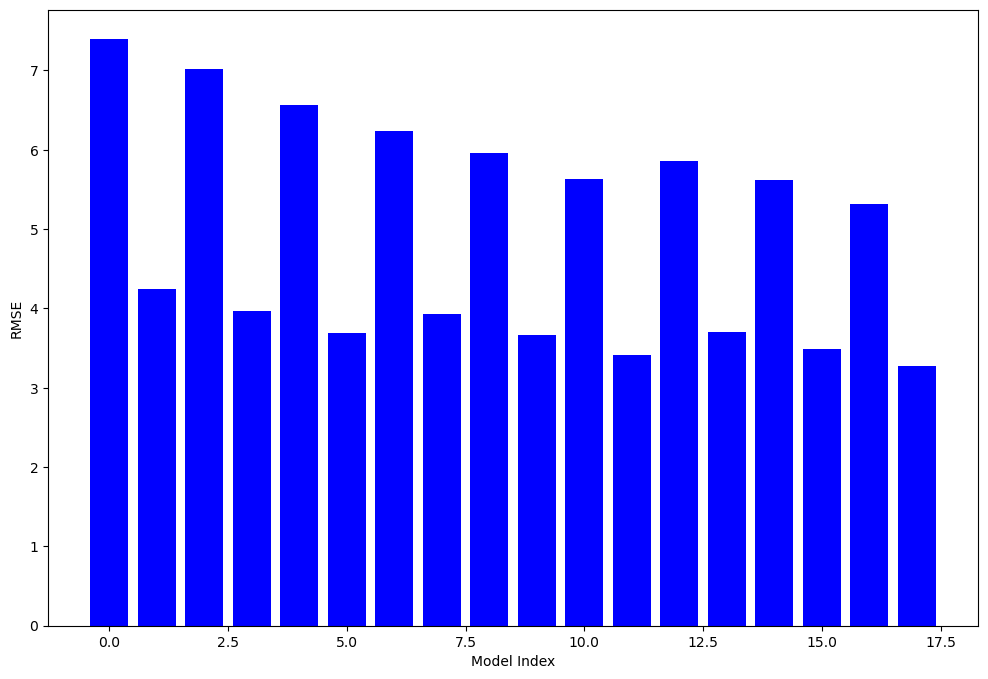

In [40]:
results_df = pd.DataFrame(results)
plt.figure(figsize=(12, 8))
plt.bar(results_df.index, results_df['rmse'], color='blue')
plt.xlabel('Model Index')
plt.ylabel('RMSE')
plt.show()

In [41]:
model=best_model

In [42]:
from pyspark.sql.functions import lit


comparison_df = predictions.select("newISBN","Book-Rating", "prediction")

comparison_pd = comparison_df.toPandas()

In [43]:
comparison_pd.head(20)

,newISBN,Book-Rating,prediction
0,53,8,3.630898
1,53,7,6.781388
2,53,10,9.177448
3,53,8,7.423463
4,53,8,7.079103
5,53,10,9.137451
6,53,7,7.088414
7,53,7,7.497637
8,53,9,8.363628
9,53,5,6.452768


## 4)Cosine Similarity

In [44]:
import numpy as np
from pyspark.sql.functions import col
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

def cosineSimilarity(item_id1, item_id2, a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    cos_similarity = dot_product / (norm_a * norm_b)
    return item_id1, item_id2, cos_similarity

In [47]:
item_id1 = 53
item_id2 = 53

In [48]:
item_vector1 = model.itemFactors.filter(col("id") == item_id1).select("features").collect()[0]["features"]
item_vector2 = model.itemFactors.filter(col("id") == item_id2).select("features").collect()[0]["features"]

In [49]:
cosineSimilarity(item_id1,item_id2,item_vector1,item_vector2)

(53, 53, 1.0)

# 5)Recommend System

In [50]:
from pyspark.sql.functions import col

def getUsersForBook(bookISBN, numUsers, Users):
    bookUsers = model.recommendForAllItems(numUsers).filter(col("newISBN") == bookISBN)
    userDF = spark.createDataFrame(bookUsers.collect()[0].recommendations)
    
    userDF = userDF.join(Users, userDF["User-ID"] == Users["User-ID"], "inner") \
                           .select(userDF["User-ID"], Users["Location"], Users["Age"], userDF["Rating"])
    
    return userDF



In [51]:
topUsersForBook = getUsersForBook(146680, 10,users)
topUsersForBook.show()

IndexError: list index out of range

In [ ]:
train.show(20)